In [325]:
import sys, os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import copy
import pickle

# for entropy
import zlib
import re
import math
from io import StringIO
from sklearn.linear_model import LinearRegression

import pylab 
import scipy.stats as stats
from scipy.stats import entropy
from scipy.stats import bernoulli
from math import log, e
import timeit
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA

import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
from mrsc.src.entropy_test import utils

plt.rcParams.update({'font.size': 14})

# LZW Compression

# Test 1. sys.getsizeof(X) vs. len(X)

In [3]:
ratio_list_sys =[]
ratio_list_len =[]
p = [1/2, 1/2]
for size in np.logspace(3,27,9, base=2, dtype=int):
    print("size: ", size)
    uncompressed = multinomial(size, p)
    uncompressed = list_to_string(uncompressed)
    compressed = compress(uncompressed)
    
    # sys.getsizeof()
    compression_ratio = sys.getsizeof(compressed)/sys.getsizeof(uncompressed)
    ratio_list_sys.append(compression_ratio)
    print("measured using sys.getsizeof(): ", compression_ratio)
    
    # len()
    compression_ratio = len(compressed)/len(uncompressed)
    ratio_list_len.append(compression_ratio)
    print("measured using len():           ", compression_ratio)
    print()

size:  8
measured using sys.getsizeof():  2.245614035087719
measured using len():            0.625

size:  64
measured using sys.getsizeof():  2.336283185840708
measured using len():            0.390625

size:  512
measured using sys.getsizeof():  1.910873440285205
measured using len():            0.228515625

size:  4096
measured using sys.getsizeof():  1.325934861278649
measured using len():            0.151123046875

size:  32768
measured using sys.getsizeof():  0.9178169850991864
measured using len():            0.109893798828125

size:  262144
measured using sys.getsizeof():  0.7640173460008467
measured using len():            0.08521652221679688

size:  2097152
measured using sys.getsizeof():  0.5598166317868435
measured using len():            0.06928825378417969

size:  16777216
measured using sys.getsizeof():  0.5184077380908032
measured using len():            0.05820530652999878

size:  134217728
measured using sys.getsizeof():  0.4266174666266451
measured using len():      

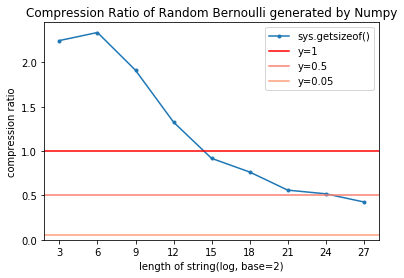

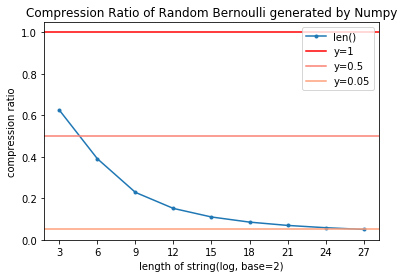

In [4]:
##### sys.getsizeof() plot
plt.plot(ratio_list_sys, marker='.', label="sys.getsizeof()")

plt.axhline(1, c="red", label="y=1")
plt.axhline(0.5, c="salmon", label="y=0.5")
plt.axhline(0.05, c="lightsalmon", label="y=0.05")

plt.xticks(np.arange(9),np.linspace(3,27,9, dtype=int))
plt.legend()
plt.xlabel("length of string(log, base=2)")
plt.ylabel("compression ratio")
plt.ylim(0,)
plt.title("Compression Ratio of Random Bernoulli generated by Numpy")
plt.show()

##### len() plot
plt.plot(ratio_list_len, marker='.', label="len()")

plt.axhline(1, c="red", label="y=1")
plt.axhline(0.5, c="salmon", label="y=0.5")
plt.axhline(0.05, c="lightsalmon", label="y=0.05")

plt.xticks(np.arange(9),np.linspace(3,27,9, dtype=int))
plt.legend()
plt.xlabel("length of string(log, base=2)")
plt.ylabel("compression ratio")
plt.ylim(0,)
plt.title("Compression Ratio of Random Bernoulli generated by Numpy")
plt.show()

# Test 2. regression model for a fixed input string size N

## Binary

In [327]:
def regression_model(size, number_of_p=30, verbose=False):
    ratio_list =[]
    true_entropy = []
    for p0 in np.linspace(1e-5,0.5,number_of_p):
        p = [p0, 1-p0]
        true_entropy.append(entropy(p))
        uncompressed = multinomial(size, p)
        uncompressed = list_to_string(uncompressed)
        compressed = compress(uncompressed)
        compression_ratio = len(compressed)/len(uncompressed)
        ratio_list.append(compression_ratio)
        
        if verbose:
            print("p : ", p)
            print("theoretical entropy: ", entropy([p,1-p]))
            print("compression ratio: ", compression_ratio)
            print()

    # linear regression
    reg = LinearRegression().fit(np.array(true_entropy[:]).reshape(-1, 1), np.array(ratio_list[:]))
    print("y = ax + b model")
    print("a = ", reg.coef_)
    print("b = ", reg.intercept_)

    plt.plot(true_entropy, ratio_list, marker='.', label = "LZW compressor")
    plt.plot(true_entropy, reg.predict(np.array(true_entropy).reshape(-1,1)), label="regression")

    plt.title("Compression Ratio of size {} Bernoulli(p), 0<p<0.5".format(size))
    plt.xlabel("theoretical entropy")
    plt.ylabel("compression ratio")
    plt.legend()
    plt.show()

    return ratio_list, true_entropy

def get_entropy(size, compression_ratio):
    # mapping compression ratio to entropy
    ratio_list, true_entropy = regression_model(size, number_of_p=30, verbose=False)
    reg_inv = LinearRegression().fit(np.array(ratio_list[:]).reshape(-1, 1), np.array(true_entropy[:]))
    return reg_inv.predict(np.array(compression_ratio).reshape(-1, 1))

def f(p):
    return -p*log(p,2) - (1-p)*log(1-p,2)

def df(p):
    return -log(p/(1-p),2) 

def inverse_binary_entropy(H, a=0.001):
    # from entropy value, get p s.t. 0 < p < 0.5
    # a = accuracy
    p_hat = 0.25
    err = np.abs(f(p_hat) - H)
    while(err > a):
        err = np.abs(f(p_hat) - H)
        p_hat = p_hat - 0.01* (f(p_hat) - H) * df(p_hat)
        if (p_hat<0):
            p_hat = e-15
        if (p_hat>0.5):
            p_hat = 0.5
    
    return p_hat

y = ax + b model
a =  [0.19508365]
b =  0.03851908887469996


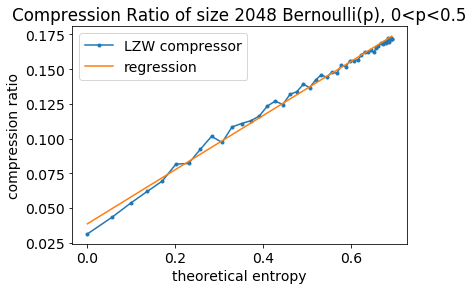

In [328]:
power = 11
size = 2 ** power

ratio_list, true_entropy = regression_model(size, number_of_p=50, verbose=False)
reg_inv = LinearRegression().fit(np.array(ratio_list[:]).reshape(-1, 1), np.array(true_entropy[:]))

regression model for a fixed input string size N, multinomial case

## Ternary

In [329]:
def regression_model_ternary(size, number_of_p=30, verbose=False):
    ratio_list =[]
    true_entropy = []
    
    probabilities=[]
    for i in range(number_of_p):
        p1= np.random.uniform(0,1,1)[0]
        p2 = np.random.uniform(0,1,1)[0]
        p3 = np.random.uniform(0,1,1)[0]
        
        probabilities.append([p1,p2,p3]/(p1+p2+p3))
            
    for p in probabilities:
        true_entropy.append(entropy(p))
        uncompressed = list_to_string(multinomial(size, p))
        compressed = compress(uncompressed)
        compression_ratio = len(compressed)/len(uncompressed)
        ratio_list.append(compression_ratio)
        
        if verbose:
            print("p : ", p)
            print("theoretical entropy: ", entropy(p))
            print("compression ratio: ", compression_ratio)
            print()

    # linear regression
    reg = LinearRegression().fit(np.array(true_entropy[:]).reshape(-1, 1), np.array(ratio_list[:]))
    print("y = ax + b model")
    print("a = ", reg.coef_)
    print("b = ", reg.intercept_)

    plt.scatter(true_entropy, ratio_list, marker='.', label = "LZW compressor")
    plt.plot(true_entropy, reg.predict(np.array(true_entropy).reshape(-1,1)), label="regression", color="orange")

    plt.title("Compression Ratio for Multinomial(3,p) with Size {}".format(size))
    plt.xlabel("theoretical entropy")
    plt.ylabel("compression ratio")
    plt.legend()
    plt.show()

    return ratio_list, true_entropy

p :  [0.26256012 0.37060966 0.36683022]
theoretical entropy:  1.0868624135255782
compression ratio:  0.2412109375

p :  [0.27174756 0.64193364 0.0863188 ]
theoretical entropy:  0.850060920606208
compression ratio:  0.19580078125

p :  [0.65139034 0.33193642 0.01667323]
theoretical entropy:  0.7135388087474293
compression ratio:  0.171875

p :  [0.02190864 0.4498015  0.52828986]
theoretical entropy:  0.7801857016457401
compression ratio:  0.1865234375

p :  [0.46902402 0.19344689 0.3375291 ]
theoretical entropy:  1.0394755648940275
compression ratio:  0.23486328125

p :  [0.19628715 0.36378831 0.43992455]
theoretical entropy:  1.0486917037863455
compression ratio:  0.234375

p :  [0.16877592 0.46132166 0.36990241]
theoretical entropy:  1.0250631930144143
compression ratio:  0.228515625

p :  [0.50036323 0.30236604 0.19727073]
theoretical entropy:  1.0283326975408422
compression ratio:  0.22900390625

p :  [0.74131124 0.2248448  0.03384396]
theoretical entropy:  0.6720416354390356
compre

compression ratio:  0.17724609375

p :  [0.48956029 0.37928135 0.13115836]
theoretical entropy:  0.9838003542254115
compression ratio:  0.22119140625

p :  [0.27798449 0.28958378 0.43243173]
theoretical entropy:  1.0772780537388016
compression ratio:  0.240234375

p :  [0.0826619  0.40432874 0.51300936]
theoretical entropy:  0.9146202638876626
compression ratio:  0.208984375

p :  [0.52785388 0.28994957 0.18219655]
theoretical entropy:  1.0064567523771395
compression ratio:  0.2265625

p :  [0.11954854 0.00630179 0.87414967]
theoretical entropy:  0.40343203517925863
compression ratio:  0.12060546875

p :  [0.42243804 0.21104777 0.36651419]
theoretical entropy:  1.0602178863306766
compression ratio:  0.23193359375

p :  [0.40119348 0.00753737 0.59126915]
theoretical entropy:  0.7139588247678347
compression ratio:  0.1787109375

p :  [0.27721469 0.46352578 0.25925953]
theoretical entropy:  1.0620391462500003
compression ratio:  0.234375

p :  [0.05366709 0.52756517 0.41876774]
theoretica

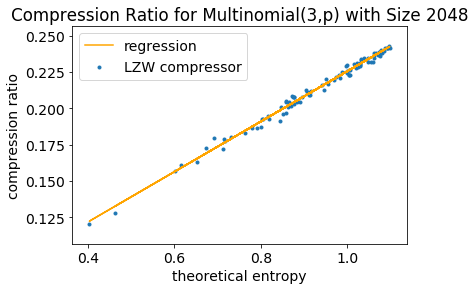

In [333]:
power = 11
size = 2 ** power

ratio_list, true_entropy = regression_model_ternary(size, number_of_p=100, verbose=True)
reg_inv = LinearRegression().fit(np.array(ratio_list[:]).reshape(-1, 1), np.array(true_entropy[:]))

y = ax + b model
a =  [0.29814386]
b =  0.270885619607898


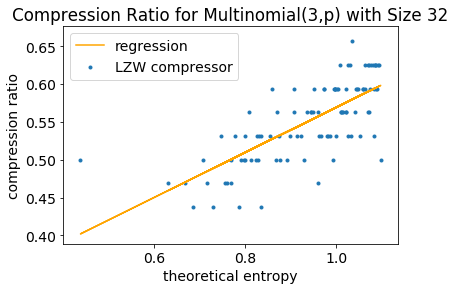

y = ax + b model
a =  [0.18679549]
b =  0.0699177711224884


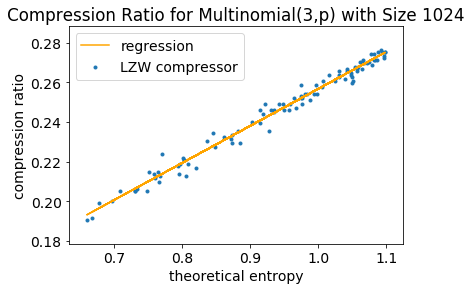

KeyboardInterrupt: 

In [331]:
for power in np.linspace(5,30,6):
    size = int(2 ** power)

    ratio_list, true_entropy = regression_model_ternary(size, number_of_p=100, verbose=False)
    reg_inv = LinearRegression().fit(np.array(ratio_list[:]).reshape(-1, 1), np.array(true_entropy[:]))

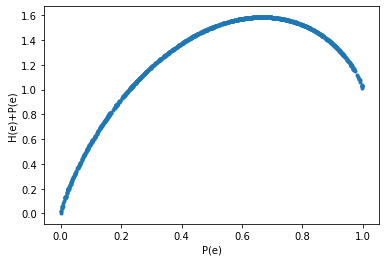

In [322]:
def g(p):
    return entropy([p,1-p]) + p

x_list = []
y_list = []
for i in range(1000):
    p = np.random.uniform(0,1,1)[0]
    g_p = g(p)
    
    x_list.append(p)
    y_list.append(g_p)
    
plt.scatter(x_list, y_list, marker='.')
plt.xlabel("P(e)")
plt.ylabel("H(e)+P(e)")
plt.show()

In [324]:
entropy([0.3,0.7])

0.8812908992306927

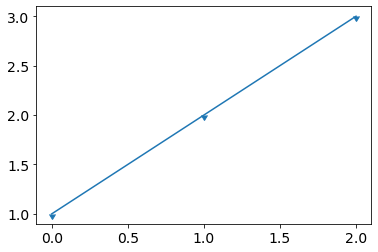

In [332]:
plt.plot([1,2,3], marker=11)
plt.show()

y = ax + b model
a =  [0.17442976]
b =  0.05154813409492687


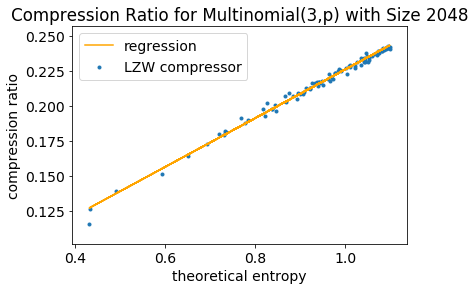

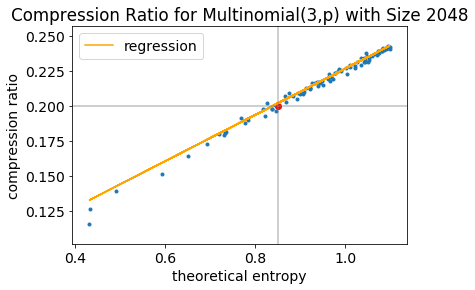

In [361]:
ratio_list, true_entropy = regression_model_ternary(size, number_of_p=100, verbose=False)
plt.scatter(true_entropy, ratio_list, marker='.')
plt.plot(true_entropy, reg.predict(np.array(true_entropy).reshape(-1,1)), label="regression", color="orange")
plt.axvline(ent, color="grey", alpha=0.5)
plt.axhline(compression_ratio, color="grey", alpha=0.5)
plt.scatter(ent, compression_ratio, color="red")

plt.title("Compression Ratio for Multinomial(3,p) with Size {}".format(size))
plt.xlabel("theoretical entropy")
plt.ylabel("compression ratio")
plt.legend()
plt.show()